# 0. Download the dataset, this one uses the Real mini dataset, which is a tiny subset of the Real Dataset.

In [4]:
# Get the original dataset from here
# !wget http://download.cs.stanford.edu/orion/nocs/real_test.zip
# !wget http://download.cs.stanford.edu/orion/nocs/obj_models.zip
# !unzip -qo real_test.zip
# !unzip -qo obj_models.zip
# or
!wget -q https://github.com/AYESDIE/RealMini/releases/download/v1/obj_models_real_test.zip
!wget -q https://github.com/AYESDIE/RealMini/releases/download/v1/real_test_scene_0.zip
!unzip -qo obj_models_real_test.zip
!unzip -qo real_test_scene_0.zip

# 1. Imports and variables


In [7]:
!pip install -q open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.6 MB/s eta 0:00:00


In [11]:
import os
import cv2
import matplotlib
import numpy
import pickle
import open3d as o3d
import plotly.subplots
import plotly.graph_objects

import sklearn.neighbors

In [9]:
image_path = "real_test/scene_1/0000_color.png"
label_path = "real_test/scene_1/0000_label.pkl"
coord_path = "real_test/scene_1/0000_coord.png"
depth_path = "real_test/scene_1/0000_depth.png"
mask_path = "real_test/scene_1/0000_mask.png"
meta_path = "real_test/scene_1/0000_meta.txt"

exact_laptop_path = "obj_models/real_test/laptop_air_xin_norm.obj"

In [12]:
# In case using RealMini
if os.path.exists("real_test/scene_0"):
  os.rename("real_test/scene_0", "real_test/scene_1")

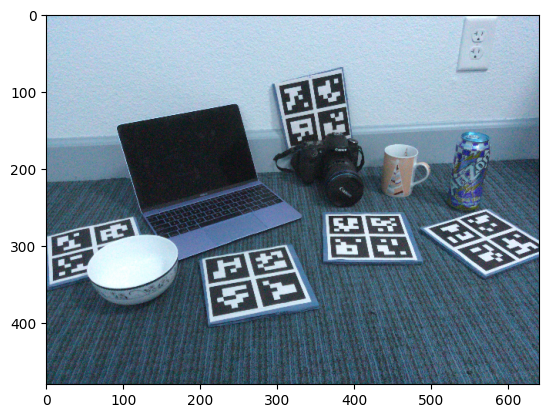

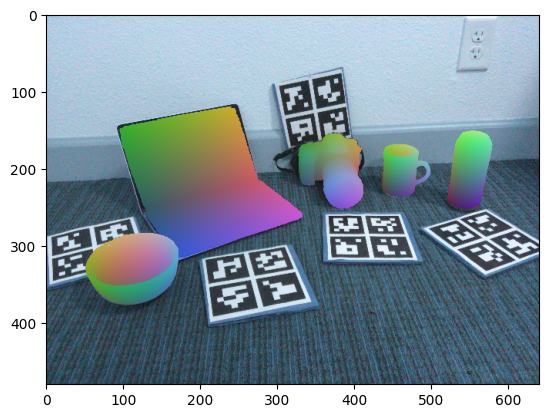

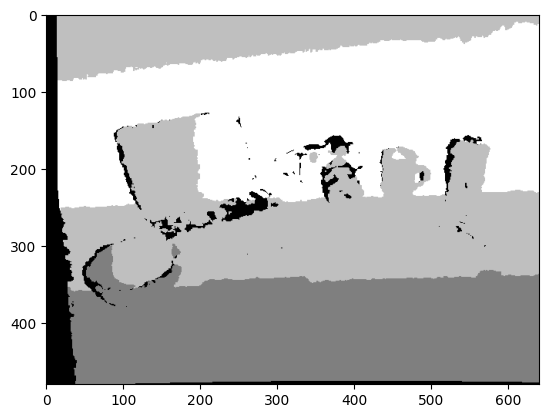

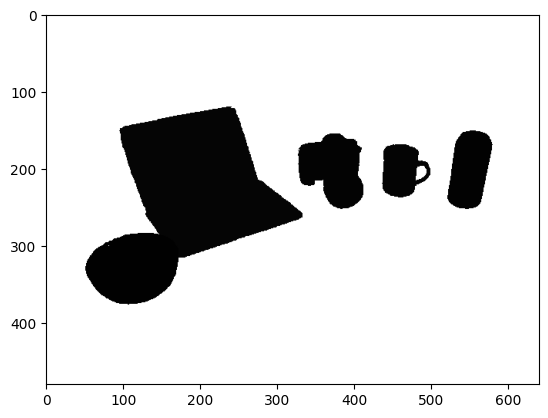

In [13]:
image = cv2.imread(image_path)
coord = cv2.imread(coord_path)
depth = cv2.imread(depth_path)
mask = cv2.imread(mask_path)

matplotlib.pyplot.imshow(image)
matplotlib.pyplot.show()
matplotlib.pyplot.imshow(coord)
matplotlib.pyplot.show()

# Normalize depth map to 0-255
min_depth = numpy.min(depth)
max_depth = numpy.max(depth)
normalized_depth = ((depth - min_depth) / (max_depth - min_depth) * 255).astype(numpy.uint8)

matplotlib.pyplot.imshow(normalized_depth)
matplotlib.pyplot.show()

matplotlib.pyplot.imshow(mask)
matplotlib.pyplot.show()

### Nocs implementation following: https://github.com/hustvl/Query6DoF/blob/main/dataset/pose_dataset.py

Edits include:
- removing reference to self,
- only focusing on laptop (inst_id 5) for image 0000 in scene_1



In [14]:
def nocs_from_repo(img_path, mask_path, depth_path):
  depth = cv2.imread(depth_path, -1)
  if len(depth.shape) == 3:
      depth16 = 256*(depth[:, :, 1]) + depth[:, :, 2]
      depth16 = np.where(depth16==32001, 0, depth16)
      depth = depth16.astype(np.uint16)
  elif len(depth.shape) == 2 and depth.dtype == 'uint16':
      depth = depth
  else:
      assert False, '[ Error ]: Unsupported depth type.'

  mask = cv2.imread(mask_path)[:, :, 2]

  coord = cv2.imread(img_path)[:, :, :3]
  coord = coord[:, :, (2, 1, 0)]
  coord = numpy.array(coord, dtype=numpy.float32) / 255
  coord[:, :, 2] = 1 - coord[:, :, 2]

  inst_id = 5

  mask = numpy.equal(mask, inst_id)

  mask = numpy.logical_and(mask, depth > 0)
  mask = mask.flatten()



  depth_masked=(depth.flatten())[mask]  #N


  xmap = numpy.array([[i for i in range(640)] for j in range(480)])
  ymap = numpy.array([[j for i in range(640)] for j in range(480)])

  xmap_masked=(xmap.flatten())[mask]
  ymap_masked=(ymap.flatten())[mask]

  norm_scale = 1000.0
  cam_fx, cam_fy, cam_cx, cam_cy = [591.0125, 590.16775, 322.525, 244.11084]

  pt2=depth_masked/norm_scale
  pt0 = (xmap_masked - cam_cx) * pt2 / cam_fx
  pt1 = (ymap_masked - cam_cy) * pt2 / cam_fy
  points=numpy.stack((pt0,pt1,pt2),axis=1)  #N,3

  n_pts = 1024

  l_all=points.shape[0]

  choose=numpy.random.choice(l_all,n_pts,replace=True)

  nocs_points = coord.reshape(-1,3)[mask,...][choose, :] - 0.5

  return nocs_points

nocs_repo = nocs_from_repo(coord_path, mask_path, depth_path)

### This is my custom nocs implementation using the cad model directly.

In [15]:
def sample_points(points, n_points, sample_type):
  if sample_type == "random_sample":
    return points[numpy.random.choice(points.shape[0], n_points)]
  else:
    return points


def calculate_nocs(points):
    points = sample_points(points, 1024, "random_sample")
    centroid = points.mean(axis = 0)
    centered_points = points - centroid
    shift = - centroid

    size = 2 * numpy.amax(numpy.abs(centered_points), axis = 0)
    scale = 1 / numpy.linalg.norm(size)

    scaled_points = centered_points * scale  * numpy.array([[1.0, 1.0, -1.0]])

    return scaled_points, shift, scale

point_cloud = o3d.io.read_triangle_mesh(exact_laptop_path)
points = numpy.asarray(point_cloud.vertices)
nocs_points, shift, scale = calculate_nocs(points)

In [16]:
# I made it with GPT
def chamfer_distance(P1, P2):
    # Build KDTree for efficient nearest-neighbor search
    tree1 = sklearn.neighbors.KDTree(P2)
    tree2 = sklearn.neighbors.KDTree(P1)

    # Forward distances: P1 -> P2
    dist1, _ = tree1.query(P1, k=1)
    forward_distance = numpy.mean(dist1**2)

    # Backward distances: P2 -> P1
    dist2, _ = tree2.query(P2, k=1)
    backward_distance = numpy.mean(dist2**2)

    # Chamfer Distance
    return forward_distance + backward_distance

In [17]:
def viz(points, points_1, points_1_name, points_2, points_2_name):
  fig = plotly.subplots.make_subplots(
      rows=1, cols=3,
      subplot_titles=("Original Point Cloud", points_1_name, points_2_name),
      specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'},  {'type': 'scatter3d'}]])

  fig.add_trace(
      plotly.graph_objects.Scatter3d(
          x=points[:, 0],
          y=points[:, 1],
          z=points[:, 2],
          mode='markers',
          marker=dict(size=1, color='red'),
          name='Original Point Cloud'
      ),
      row=1, col=1
  )

  fig.add_trace(
      plotly.graph_objects.Scatter3d(
          x=points_1[:, 0],
          y=points_1[:, 1],
          z=points_1[:, 2],
          mode='markers',
          marker=dict(size=1, color='blue'),
          name=points_1_name
      ),
      row=1, col=2
  )

  fig.add_trace(
      plotly.graph_objects.Scatter3d(
          x=points_2[:, 0],
          y=points_2[:, 1],
          z=points_2[:, 2],
          mode='markers',
          marker=dict(size=1, color='green'),
          name=points_2_name
      ),
      row=1, col=3
  )

  fig.update_layout(
      title_text=f"Point Cloud, {points_1_name} and {points_2_name} | Chamfer distance between nocs1 and nocs2 is {chamfer_distance(points_1, points_2)}",
      scene=dict(aspectmode='data'),
      scene2=dict(aspectmode='data'),
      scene3=dict(aspectmode='data'),
      height=500,
      width=1600
  )

  fig.show()
  fig.write_html(f"point_cloud_and_{points_1_name}_and_{points_2_name}.html")

In [18]:
viz(points, nocs_points, "NOCS Points", nocs_repo, "NOCS Points from repo implementation")

In [19]:
impostor_point_cloud = o3d.io.read_triangle_mesh("obj_models/real_test/bottle_shampoo_norm.obj")
impostor_points = numpy.asarray(impostor_point_cloud.vertices)
impostor_nocs_points, shift, scale = calculate_nocs(impostor_points)

viz(points, impostor_nocs_points, "Impostor NOCS Points", nocs_repo, "NOCS Points from repo implementation")